In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

# Preparacion de los datos

importar matriz de datos con los resultados y dividir en entrada(x) y salida(y)

In [2]:
file_path = 'matriz_datos_resultados.xlsx'
# Load the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='Limpio')
# Assigning x and y variables
x = df[['y1', 'G_', 'wt_mea', 'z', 'T_gas', 'L_']]
y = df[['kGa (kmol/m³*hr*kPa)']]

In [3]:
# Initialize the MinMaxScaler
scaler_y = MinMaxScaler()
scaler = MinMaxScaler()

# Fit and transform the x variables
x_normalized = scaler.fit_transform(x)
y_normalized = scaler_y.fit_transform(y)

# Convert the normalized data back to a DataFrame
x_normalized_df = pd.DataFrame(x_normalized, columns=['y1', 'G_', 'wt_mea', 'z', 'T_gas', 'L_'])
y_normalized_df = pd.DataFrame(y_normalized, columns=['kG (mol/m²*s*kPa)'])


#Export normalization
#joblib.dump(scaler, 'minmax_scaler_X.pkl')
#joblib.dump(scaler_y, 'minmax_scaler_Y.pkl')

Separando en train-test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x_normalized_df, y, test_size=0.2, random_state=42)

In [7]:
# Build the neural network model
model = Sequential()
model.add(Dense(872, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(864, activation='sigmoid'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0)

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

c:\Users\PcR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.6120e-08 - mae: 2.2373e-04
Test Loss: 5.61201254356547e-08
Test MAE: 0.00022372549574356526


In [9]:
import csv

with open('pesos_y_sesgos.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Capa', 'Tipo', 'Valores'])  # Encabezado

    for i, layer in enumerate(model.layers):
        weights, biases = layer.get_weights()

        # Aplanamos las matrices/vectores para guardarlos en una sola fila
        for w in weights.flatten():
            writer.writerow([i+1, 'Peso', w])
        for b in biases.flatten():
            writer.writerow([i+1, 'Sesgo', b])

In [51]:
def train_until_mae_below_threshold_enhanced(X_train, y_train, X_test, y_test, initial_config, threshold):
    # Initialize training parameters
    config = initial_config.copy()
    best_mae = float('inf')  # Track best MAE
    log_path = "training_log.txt"

    # Open the log file
    with open(log_path, "w") as log_file:
        log_file.write("Training Start Time: {}\n".format(datetime.datetime.now()))
        
        # Possible activation functions to cycle through
        activations = ['relu', 'sigmoid', 'relu']
        i = 0
        input_dim = X_train.shape[1]
        
        while True:
            # Create model with dynamic activations
            model = Sequential([
                Dense(config['neurons'][0], activation=activations[0], input_shape=(input_dim,)),
                Dense(config['neurons'][1], activation=activations[1]),
                Dense(1, activation='linear')
            ])
            model.compile(optimizer='adam', loss='mean_squared_error')

            # Fit model
            i += 1
            history = model.fit(X_train, y_train, epochs=100, batch_size=config['batch_size'], validation_split=config['val_split'], verbose=0)
            
            # Predict and evaluate
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            log_file.write("Config: {}, MAE: {}\n".format(config, mae))
            
            # If mae is > than 0.005 train it 5 times and see if it goes down
            if mae < 0.0005:
                r = 0
                while r < 5:
                    print('LESS than 0.00005, try number: ' + str(r))
                    history = model.fit(X_train, y_train, epochs=100, batch_size=config['batch_size'], validation_split=config['val_split'], verbose=0)
                    y_pred = model.predict(X_test)
                    mae = mean_absolute_error(y_test, y_pred)
                    print('MAE with the same configurations: ' + str(mae))
                    r += 1
                    if mae < best_mae:
                        best_mae = mae
                        best_model_path = "best_model.h5"
                        model.save(best_model_path)
                        print('NEW BEST MODEL SAVED with MAE: ' + str(mae))
                        log_file.write("New best model saved with MAE: {} at {}\n".format(best_mae, best_model_path))

            if mae < best_mae:
                best_mae = mae
                best_model_path = "best_model.h5"
                model.save(best_model_path)
                print('NEW BEST MODEL SAVED with MAE: ' + str(mae))
                log_file.write("New best model saved with MAE: {} at {}\n".format(best_mae, best_model_path))
            
            # Check if the MAE threshold is met
            if mae < threshold:
                print("Broke threshhold")
                break
            
            # Adjust parameters if needed
            # Cycle activations
            activations = activations[1:] + activations[:1]
            
            # Increase neurons
            config['neurons'] = [n + 2 for n in config['neurons']]
            
            # Adjust validation split
            config['val_split'] = random.uniform(0.2, 0.01)
            
            # Adjust batch size
            config['batch_size'] = random.randint(10, 33)

    return model, history

In [53]:
initial_config = {
    'neurons': [16, 8],  # Número inicial de neuronas en cada capa
    'batch_size': 10,     # Tamaño de lote inicial
    'val_split': 0.2      # Proporción de datos de validación inicial
}

In [ ]:
model, history = train_until_mae_below_threshold_enhanced(X_train, y_train, X_test, y_test, initial_config, threshold=0.0002)

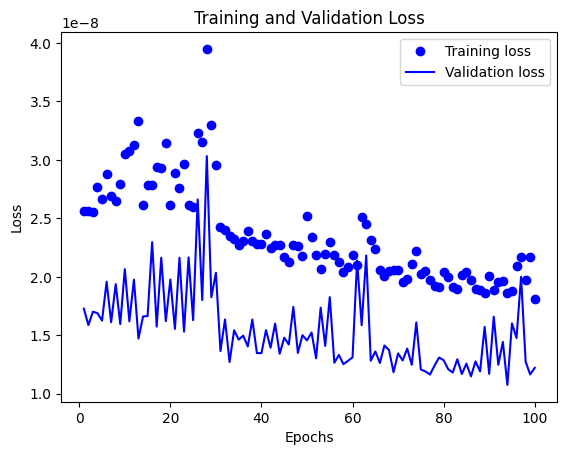

In [49]:
# Assuming history is returned by model.fit
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
# Plotting the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')  # 'bo' gives us blue dot
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # 'b' gives us a solid blue line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print the metrics
print(f'R-squared (R2): {r2:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.6f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
R-squared (R2): 0.99
Mean Squared Error (MSE): 0.00
Mean Absolute Error (MAE): 0.000125
Root Mean Squared Error (RMSE): 0.00
